In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import pandas as pd
import numpy as np

# Step 1: Load CSV Data
df = pd.read_csv('/Users/Nufail/Desktop/Process_Mining/Process_Mining/conformance_checking/data/df_for_decision_tree.csv')

In [3]:
df.head()

,trace_number,start_log_moves,start_model_moves,A-Create-Application_log_moves,A-Create-Application_model_moves,A-Submitted_log_moves,A-Submitted_model_moves,W-Handle-leads-schedule_log_moves,W-Handle-leads-schedule_model_moves,W-Handle-leads-withdraw_log_moves,...,W-Handle-leads-ate-abort_model_moves,W-Shortened-completion-schedule_log_moves,W-Shortened-completion-schedule_model_moves,W-Shortened-completion-start_log_moves,W-Shortened-completion-start_model_moves,W-Shortened-completion-suspend_log_moves,W-Shortened-completion-suspend_model_moves,W-Call-after-offers-withdraw_log_moves,W-Call-after-offers-withdraw_model_moves,case:throughput_time
0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13 days 15:06:16.631000
1,1,0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30 days 04:47:52.288000
2,2,0,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16 days 02:13:02.807000
3,3,0,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21 days 20:18:42.905000
4,4,0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20 days 02:25:54.292000


In [25]:
df.shape

(3093, 112)

In [9]:
type(df['case:throughput_time'])

pandas.core.series.Series

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import tree
import matplotlib.pyplot as plt

# Replace NaN values with 0 for moves not made and ensure -1 for activities not present in trace
df_filled = df.fillna(0).replace(0, -1)  # NaNs -> 0, then replace 0 with -1 for non-participating moves

# Separate features (X) and target (y)
X = df_filled.drop(columns=["trace_number", "case:throughput_time"])
y = df_filled["case:throughput_time"].apply(pd.to_timedelta)  # Ensure column is timedelta

# Convert target variable 'case:throughput_time' to numeric (hours) for modeling
y_hours = y.apply(lambda x: x.total_seconds() / 3600)  # Convert timedelta to hours

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_hours, test_size=0.2, random_state=42)

# Define the Decision Tree model with restricted hyperparameters for interpretability
tree_regressor = DecisionTreeRegressor(random_state=42)

# Enhanced parameter grid for GridSearchCV
param_grid = {
    'max_depth': [3, 5, 7],            # Allow deeper trees for better capture of complexity
    'min_samples_split': [20, 40, 60, 80, 100],           # Additional split options for better tuning on varied data
    'min_samples_leaf': [20, 30, 40, 50],            # Minimum leaf sizes, including smaller sizes for potential precision
    'max_features': [5, 7, 8, 10, 12]    # Limit to subsets of features but include some percentages for flexibility
}

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=tree_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)


Model Performance:
Best Parameters: {'max_depth': 5, 'max_features': 10, 'min_samples_leaf': 50, 'min_samples_split': 20}
Mean Absolute Error (MAE): 161.71 hours
Root Mean Squared Error (RMSE): 233.09 hours
R-squared (R2): 0.18
  Actual Throughput Time (Hours) Predicted Throughput Time (Hours)
0     20 days 00:56:41.258000400           14 days 22:03:01.021608
1     41 days 08:53:06.929998800           19 days 19:19:44.784246
2      8 days 11:57:34.908998400        20 days 10:15:08.161628400
3     21 days 18:28:18.203998800        20 days 10:15:08.161628400
4      0 days 00:57:59.281999200         8 days 01:10:20.313091200


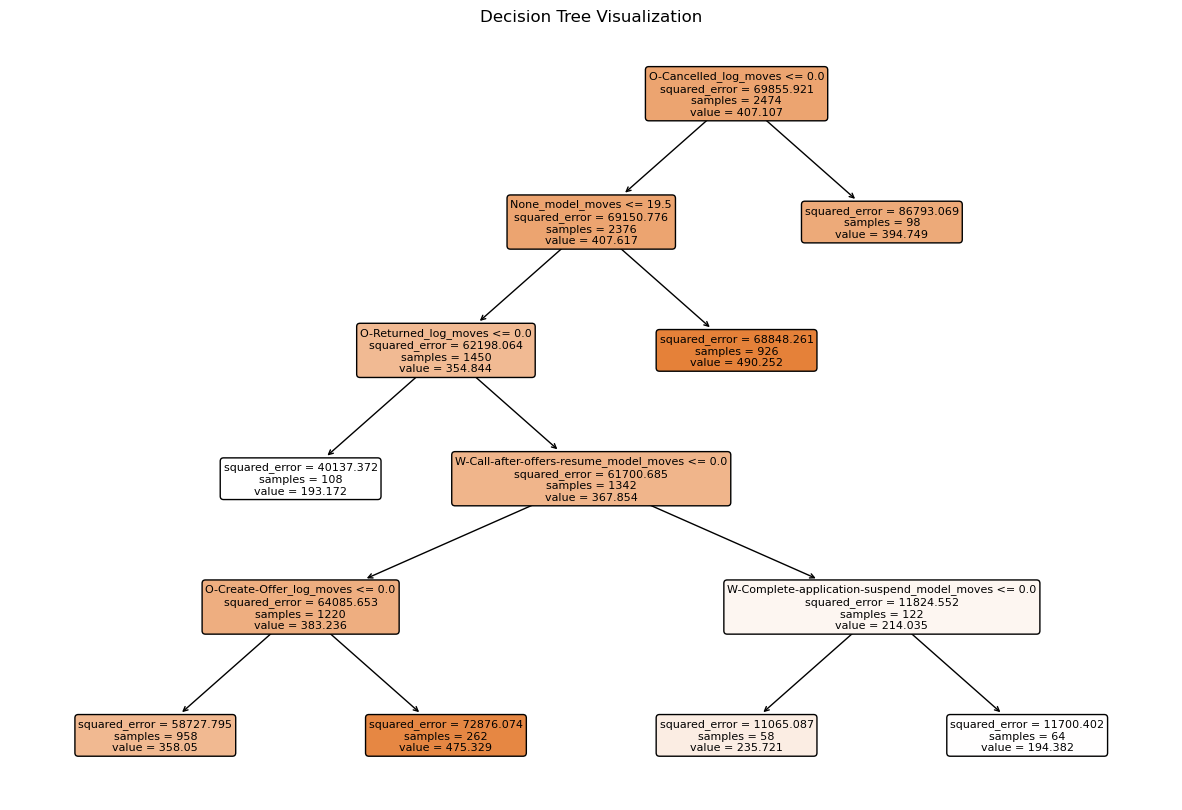

In [10]:

# Extract the best model from the grid search
best_tree_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred_hours = best_tree_model.predict(X_test)

# Convert predictions back to timedelta format for interpretation
y_pred_timedelta = pd.Series(y_pred_hours).apply(lambda hours: pd.to_timedelta(hours, unit='h'))
y_test_timedelta = pd.Series(y_test).apply(lambda hours: pd.to_timedelta(hours, unit='h'))

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred_hours)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_hours))
r2 = r2_score(y_test, y_pred_hours)

print("Model Performance:")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Absolute Error (MAE): {mae:.2f} hours")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} hours")
print(f"R-squared (R2): {r2:.2f}")

# Display first few results for interpretation
results_df = pd.DataFrame({
    'Actual Throughput Time (Hours)': y_test_timedelta.reset_index(drop=True),
    'Predicted Throughput Time (Hours)': y_pred_timedelta
})
print(results_df.head())

# Visualize the decision tree to understand decision rules
plt.figure(figsize=(15, 10))
tree.plot_tree(best_tree_model, feature_names=X.columns, filled=True, rounded=True, fontsize=8)
plt.title("Decision Tree Visualization")
plt.show()

In [19]:
from typing import List, Dict, Tuple
import pandas as pd
from sklearn.tree import _tree

def extract_node_based_rules(decision_tree_model, feature_names: List[str]) -> List[Dict[str, Tuple[str, float]]]:
    """
    Extract classification rules from each node in the trained decision tree model.
    
    Parameters
    ----------
    decision_tree_model : sklearn.tree.DecisionTreeRegressor
        The trained decision tree model from which to extract node-based rules.
    feature_names : List[str]
        List of feature names to interpret tree splits.
        
    Returns
    -------
    List[Dict[str, Tuple[str, float]]]
        List of dictionaries, each representing a node-based rule.
    """
    tree_ = decision_tree_model.tree_
    rules = []

    # Traverse nodes and create rules for each decision point (node)
    def traverse_node(node, conditions):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            # Extract the rule for the current node
            feature = feature_names[tree_.feature[node]]
            threshold = tree_.threshold[node]

            # Rule for the left child (feature <= threshold)
            left_conditions = conditions + [(feature, "<=", threshold)]
            rules.append({feature: ("<=", threshold)})
            traverse_node(tree_.children_left[node], left_conditions)

            # Rule for the right child (feature > threshold)
            right_conditions = conditions + [(feature, ">", threshold)]
            rules.append({feature: (">", threshold)})
            traverse_node(tree_.children_right[node], right_conditions)
    
    # Start traversal from the root node
    traverse_node(0, [])
    return rules


def split_log_by_classification_rules(log_df: pd.DataFrame, rules: List[Dict[str, Tuple[str, float]]]) -> Dict[int, pd.DataFrame]:
    """
    Split the log into segments based on individual node rules.
    
    Parameters
    ----------
    log_df : pd.DataFrame
        The original event log data.
    rules : List[Dict[str, Tuple[str, float]]]
        Extracted node-based rules from the decision tree. Each rule is a dictionary 
        where keys are column names, and values are tuples with condition and threshold.

    Returns
    -------
    Dict[int, pd.DataFrame]
        Dictionary where keys are rule indices and values are DataFrames
        of traces that satisfy each individual node rule.
    """
    segmented_logs = {}
    
    for rule_idx, rule in enumerate(rules):
        # Apply each individual rule to filter traces
        rule_filter = pd.Series([True] * len(log_df))  # Start with all True

        for feature, (op, threshold) in rule.items():
            if op == "<=":
                rule_filter &= (log_df[feature] <= threshold)
            elif op == ">":
                rule_filter &= (log_df[feature] > threshold)
            else:
                raise ValueError(f"Unsupported operator '{op}' in rule.")
        
        # Filter the log based on the individual rule
        segment_df = log_df[rule_filter]

        if not segment_df.empty:
            segmented_logs[rule_idx] = segment_df
            print(f"Segment {rule_idx} created with {len(segment_df)} traces.")
        else:
            print(f"Rule {rule_idx} did not match any traces.")
    
    return segmented_logs


In [20]:
# Step 1: Extract individual node-based rules and print them for verification
feature_names = list(df.drop(columns=["trace_number", "case:throughput_time"]).columns)
node_based_rules = extract_node_based_rules(best_tree_model, feature_names)

if not node_based_rules:
    print("No node-based rules were extracted. Check extract_node_based_rules for issues.")
else:
    print("Extracted Node-Based Rules:")
    for i, rule in enumerate(node_based_rules, 1):
        print(f"Rule {i}: {rule}")

# Step 2: Segment the log based on individual node-based rules
segmented_logs = split_log_by_classification_rules(df, node_based_rules)

# Step 3: Output the count of traces in each segment for confirmation
if not segmented_logs:
    print("No segments were created. Check split_log_by_classification_rules for issues.")
else:
    print("Segmented Log Trace Counts:")
    for segment_label, segment_df in segmented_logs.items():
        print(f"Segment {segment_label}: {len(segment_df)} traces")


Extracted Node-Based Rules:
Rule 1: {'O-Cancelled_log_moves': ('<=', 0.0)}
Rule 2: {'None_model_moves': ('<=', 19.5)}
Rule 3: {'O-Returned_log_moves': ('<=', 0.0)}
Rule 4: {'O-Returned_log_moves': ('>', 0.0)}
Rule 5: {'W-Call-after-offers-resume_model_moves': ('<=', 0.0)}
Rule 6: {'O-Create-Offer_log_moves': ('<=', 0.0)}
Rule 7: {'O-Create-Offer_log_moves': ('>', 0.0)}
Rule 8: {'W-Call-after-offers-resume_model_moves': ('>', 0.0)}
Rule 9: {'W-Complete-application-suspend_model_moves': ('<=', 0.0)}
Rule 10: {'W-Complete-application-suspend_model_moves': ('>', 0.0)}
Rule 11: {'None_model_moves': ('>', 19.5)}
Rule 12: {'O-Cancelled_log_moves': ('>', 0.0)}
Segment 0 created with 23 traces.
Segment 1 created with 1916 traces.
Segment 2 created with 11 traces.
Segment 3 created with 2917 traces.
Segment 4 created with 2695 traces.
Segment 5 created with 2339 traces.
Segment 6 created with 754 traces.
Segment 7 created with 390 traces.
Segment 8 created with 1819 traces.
Segment 9 created wit